# <b>Contents:</b>
- Importing and reading data

### <b>Importing and reading data:</b>

In [3]:
! pip install -Uqq timm

In [15]:
!pip install fastai

In [11]:
import albumentations as A
import timm
from pathlib import Path
from fastai.vision.all import *
from fastai.vision.all import vision_learner, get_image_files

In [5]:
path = Path("/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset")
path.ls()

(#4) [Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords'),Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Valid'),Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Test'),Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Train')]

#### <b>Looking at the data</b>

In [6]:
trn_path = path/'Train'
files = get_image_files(trn_path)

(271, 186)


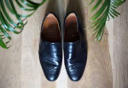

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Most of the images in the dataset can be of (271,186) , anyways we can take a look at them

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(225, 225)    2315
(183, 275)    1008
(194, 259)     994
(275, 183)     391
(199, 254)     311
              ... 
(375, 135)       1
(464, 108)       1
(350, 144)       1
(250, 155)       1
(176, 286)       1
Length: 477, dtype: int64

- Seems like the dataset consists of images of multiples sizes 
- We need to make sure the images in the dataset are of common sizes to ensure that there is no data leakage

### <b>Data Pre-processing:</b>

- We are initially squishing them into 225 * 225 images , and once they are in batches we will further resize and perform augmentations on them.

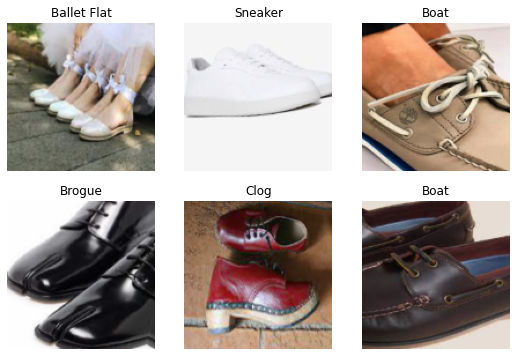

In [23]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(225, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

### <b>Baseline Model:</b>

In [24]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0006918309954926372, slide=0.009120108559727669)

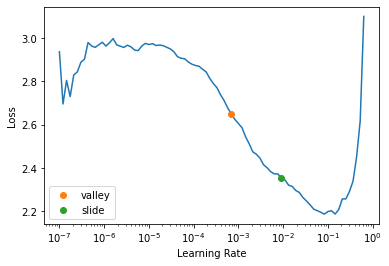

In [25]:
learn.lr_find(suggest_funcs=(valley, slide))

In [26]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.185224,0.940134,0.320000,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.784492,0.688345,0.235500,01:01
1,0.581731,0.523565,0.170000,01:02
2,0.385474,0.481816,0.159000,01:02


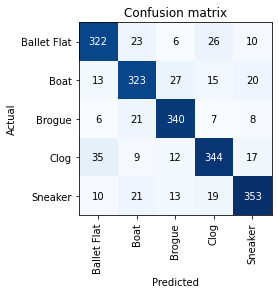

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()